# Injecting into Real Images

One of **ArtPop**'s most common use cases is generating artificial galaxies and injecting them into real imaging data. In this tutorial, we will walk you through how to do this using imaging data from the invaluable [Legacy Survey](https://www.legacysurvey.org). _HUGE_ thanks to the one and only [Dustin Lang](http://dstn.astrometry.net) for making it so easy to get these data!

**Note:** To generate synthetic photometry using **ArtPop**, first download the [MIST isochrone grids](../getting_started/mist.rst) in the photometric system(s) you want to simulate.

We have more imports than usual in this tutorial:

In [1]:
# Standard library imports
from copy import deepcopy
from io import BytesIO

# Third-party imports 
import requests
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u   
from astropy.io import fits
from astropy.visualization import make_lupton_rgb

# Project import
import artpop

# artpop's matplotlib style
plt.style.use(artpop.mpl_style)

# use this random state for reproducibility
rng = np.random.RandomState(100)

## Fetch Data

First, we define two simple functions that use the [standard io](https://docs.python.org/3/library/io.html) and [requests](https://requests.readthedocs.io/en/master/) library to fetch $grz$ coadds and point spread functions (PSFs) from the [Legacy Survey](https://www.legacysurvey.org):

In [2]:
url_prefix = 'https://www.legacysurvey.org/viewer/'

def fetch_psf(ra, dec):
    """
    Returns PSFs in dictionary with keys 'g', 'r', and 'z'.
    """
    url = url_prefix + f'coadd-psf/?ra={ra}&dec={dec}&layer=dr8&bands=grz'
    session = requests.Session()
    resp = session.get(url)
    hdulist = fits.open(BytesIO(resp.content))
    psf = {'grz'[i]: hdulist[i].data for i in range(3)}
    return psf

def fetch_coadd(ra, dec):
    """
    Returns coadds in dictionary with keys 'g', 'r', and 'z'.
    """
    url = url_prefix + f'cutout.fits?ra={ra}&dec={dec}&size=900&'
    url += 'layer=ls-dr8&pixscale=0.262&bands=grz'
    session = requests.Session()
    resp = session.get(url)
    cutout = fits.getdata(BytesIO(resp.content))
    image = {'grz'[i]: cutout[i, :, :] for i in range(3)}
    return image

Next, we grab data from a relatively empty patch of sky:

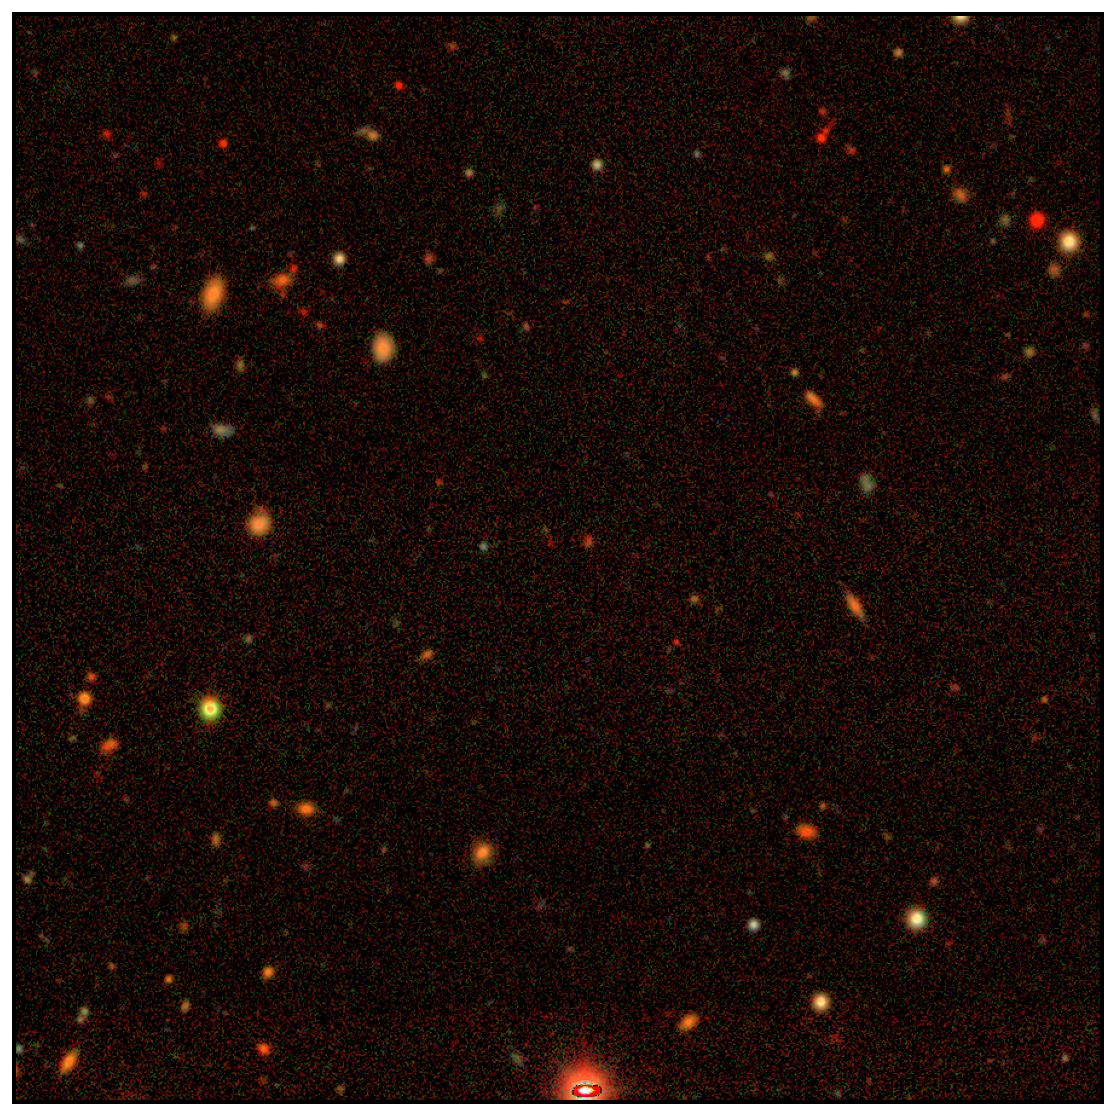

In [3]:
# random coordinates in Legacy Survey footprint
ra,dec = 182.5002, 12.5554

# grab the model grz PSFs at this location
psf = fetch_psf(ra, dec)

# grab the grz coadds at this location
real_image = fetch_coadd(ra, dec)

# see what a RGB image at this location looks like
rgb = make_lupton_rgb(real_image['z'], real_image['r'], 
                      real_image['g'], stretch=0.04)

artpop.show_image(rgb);

## Initialize Imager

The Legacy Survey data we have were observed using [DECam](http://www.ctio.noao.edu/noao/content/dark-energy-camera-decam), so we need to create an imager with this the ``DECam`` photometric system. Here, we will use the [IdealImager](../api/artpop.image.IdealImager.rst). This means our artificial source image(s) will have zero noise. If you want to include Poisson noise from the source, use the [ArtImager](../api/artpop.image.ArtImager.rst) and set `read_noise = 0` at initialization, `sky_sb = None` when you call the ``observe`` method, and use the same effective aperture diameter and exposure time as the observations. 

In [4]:
# initialize ideal imager
imager = artpop.IdealImager()

The photometric [zero point](https://www.legacysurvey.org/dr8/description/#photometry) for all bands is 22.5 and the [pixel scale](https://www.legacysurvey.org/dr8/description/#id7) is ${\sim}0.262$ arcsec / pixel:

In [5]:
zpt = 22.5
pixel_scale = 0.262

## Create Artificial Sources

Let's create two sources $-$ one dwarf that's young and relatively far away (10 Mpc) and another that's old and nearby (3 Mpc):

In [6]:
# create young source at 10 Mpc
src_young_far = artpop.MISTPlummerSSP(
    log_age = 8.5,              # log of age in years
    feh = -1,                   # metallicity [Fe/H]
    scale_radius = 300 * u.pc,  # effective radius
    total_mass = 1e6,           # total mass
    phot_system = 'DECam',      # photometric system
    distance = 10 * u.Mpc,      # distance to system
    xy_dim = 801,               # image dimension
    pixel_scale = pixel_scale,  # pixel scale in arcsec / pixel
    random_state = rng,         # random state for reproducibility
)

# create old source at 3 Mpc
src_old_near = artpop.MISTSersicSSP(
    log_age = 10.0,            # log of age in years
    feh = -1.5,                # metallicity [Fe/H]
    r_eff = 300 * u.pc,        # effective radius
    n = 0.7,                   # Sersic index
    theta = 135 * u.deg,       # position angle
    ellip = 0.3,               # ellipticity
    num_stars = 5e6,           # number of stars
    phot_system = 'DECam',     # photometric system 
    distance = 3 * u.Mpc,      # distance to system 
    xy_dim = 701,              # image dimension
    pixel_scale = pixel_scale, # pixel scale in arcsec / pixel
    random_state = rng,        # random state for reproducibility
)

## Inject into Real Image

Use the ``imager`` to mock observe our sources:

In [7]:
# create image dictionaries with keys 'g', 'r', and 'z'
img_young = {}
img_old = {}
for b in 'grz':
    # mock observe young source
    img_young[b] = imager.observe(src_young_far, 
                                  bandpass=f'DECam_{b}', 
                                  psf=psf[b], 
                                  zpt=zpt).image
    
    # mock observe old source
    img_old[b] = imager.observe(src_old_near, 
                                bandpass=f'DECam_{b}', 
                                psf=psf[b], 
                                zpt=zpt).image

The [embed_slices](../api/artpop.util.embed_slices.rst) function is useful when you want to inject a mock source into a real image with a different size and/or at a particular location.

In [8]:
# work on deep copy in case we want to make adjustments
mock_image = deepcopy(real_image)

# get slices to inject young source at (600, 700)
img_slice, arr_slice = artpop.util.embed_slices((600, 700), 
                                                img_young['g'].shape, 
                                                real_image['g'].shape)
# inject young source into image
for b in 'grz':
    mock_image[b][img_slice] += img_young[b][arr_slice]
    
# get slices to inject old source at (300, 350)
img_slice, arr_slice = artpop.util.embed_slices((300, 350), 
                                                img_old['g'].shape, 
                                                real_image['g'].shape)
# inject old source into image
for b in 'grz':
    mock_image[b][img_slice] += img_old[b][arr_slice]

Let's compare the original RGB image with the new one with artificial sources:

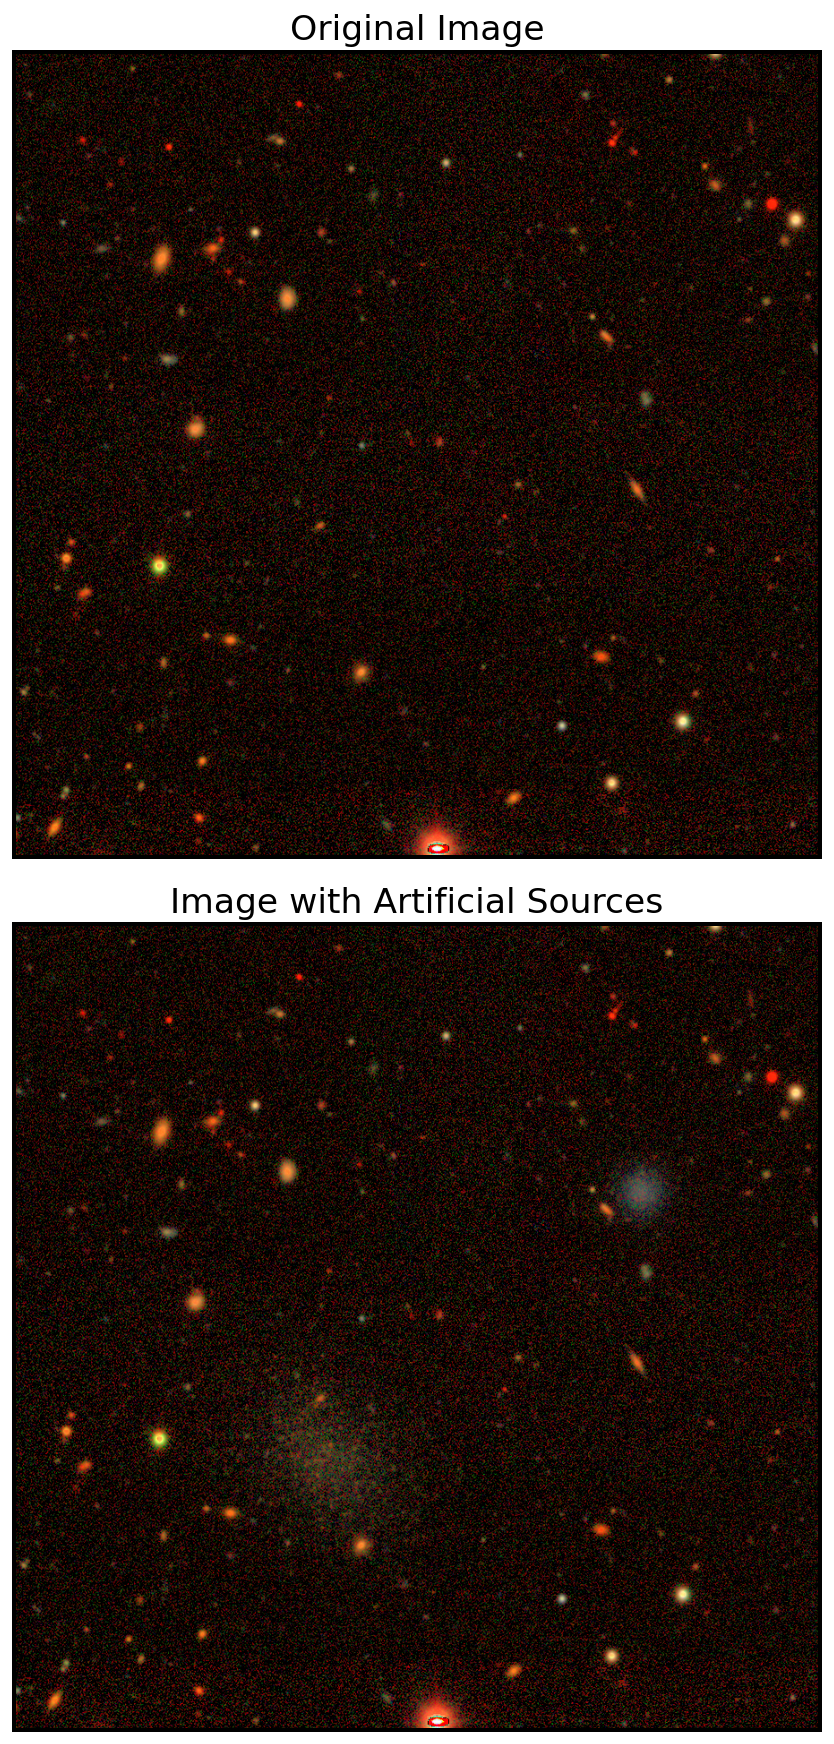

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12),
                       constrained_layout=True,
                       subplot_kw=dict(xticks=[], yticks=[], aspect='equal'))


ax[0].set_title('Original Image')
artpop.show_image(rgb, subplots=(fig, ax[0]));

ax[1].set_title('Image with Artificial Sources')
mock_rgb = make_lupton_rgb(mock_image['z'], mock_image['r'], 
                           mock_image['g'], stretch=0.04)

artpop.show_image(mock_rgb, subplots=(fig, ax[1]));